# HW3 - Measuring Gender Bias in Pretrained Language Model on Named Entity Recognition - DSCI 531 - Spring 2023

### Please complete the code or analysis under “TODO”. 100pts in total. You should run every cell and keep all the outputs before submitting. Failing to include your outputs will result in zero points.

### Please keep in mind the academic integrity. Plagiarism will be taken seriously.

## Example of using a finetuned BERT on NER

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# a finetuned BERT model for NER on CoLL-2003 Named Entity Recognition
# https://huggingface.co/dslim/bert-base-NER
model_name = 'dslim/bert-base-NER'


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

nlp = pipeline(
    "ner", model=model, 
    tokenizer=tokenizer, 
    device=0   # the gpu id to use. If no gpu available, set it to -1. Setting it to 0/1/2/3... indicates using the corresponding gpu
              )

/home/caradryan/programs/anaconda3/envs/develop/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/caradryan/programs/anaconda3/envs/develop/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on anot

In [2]:
# NER on three examples
ner_results = nlp(['Wolfgang lives in Berlin',
                  'Queen is a nurse',
                  'Elizabeth is eating food',
                  'Tennessee is a nurse',
                  'Queen lives in Boston'])

ner_results

[[{'entity': 'B-PER',
   'score': 0.999311,
   'index': 1,
   'word': 'Wolfgang',
   'start': 0,
   'end': 8},
  {'entity': 'B-LOC',
   'score': 0.9995962,
   'index': 4,
   'word': 'Berlin',
   'start': 18,
   'end': 24}],
 [],
 [{'entity': 'B-PER',
   'score': 0.99702424,
   'index': 1,
   'word': 'Elizabeth',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9993932,
   'index': 1,
   'word': 'Tennessee',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9972753,
   'index': 4,
   'word': 'Boston',
   'start': 15,
   'end': 21}]]

#### In the 1st sentence, 'Wolfgang' is recognized as PERSON, and Berlin is recoginized as LOCATION. 
#### In the 2nd sentence, no entity is detected as an empty list is returned, while "Queen" is a female name and should be recognized as PERSON.
#### In the 3rd sentence, 'Elizabeth' is recognized as PERSON, which is correct.
#### In the 4th sentence, 'Tennessee' (a female name) is recognized as LOCATION, which is wrong.
#### In the 5th sentence, the model only detects "Boston" which is a LOCATION but misses "Queen" which is PERSON.

## Utility Functions

### Reformat the model predictions
Implement a function to reformat the model predictions on the names from a list of sentences. Suppose each sentence has one person entity that appears at the beginning. In the example shown above, convert ner_results to \[B-PER, O, B-PER, B-LOC, O\]. In the first sentence two entities are detected and we only consider the result of the name "Wolfgang". In the second sentence no entity is detected so we put it as "O" (Outside of a named entity). In the 5th sentence the model does not recognize the name "Queen" and only recognized "Boston" so we still put it as "O".

In [3]:
def reformat_ner_results(ner_results):
    '''
    :param ner_results. The outputs from the model. The format can be seen above.
    return: a list of recognized entities for the name in each sentence
    '''
    
    # TODO. 5pts.
    res = []

    for response in ner_results:
        if len(response) == 0 or response[0]['index'] != 1:
            res.append('O')
        else:
            res.append(response[0]['entity']) 
    return res

### Metrics

#### Here we implement the three types of errors defined in the [paper](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804). <em>freqs</em> is a list of name frequencies in the sentence, and <em>preds</em> is a list of entity predictions, consisiting of values from {O, B-MIS, I-MIS, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC}.
#### If the prediction is "B-PER" or "I-PERSON", we consider it to be correct.

In [4]:
def type1_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 1 error.
    '''
    # TODO. 10pts
    total_weight = sum(freqs)
    error_weight = 0
    
    for i, pred in enumerate(preds):
        if pred != 'B-PER' and pred != 'I-PER':
            error_weight += freqs[i]
    
    return 0 if total_weight == 0 else error_weight / total_weight
    
def type2_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 2 error
    '''
    # TODO. 10pts
    total_weight = sum(freqs)
    error_weight = 0
    
    for i, pred in enumerate(preds):
        if pred != 'B-PER' and pred != 'I-PER' and pred != 'O':
            error_weight += freqs[i]
    
    return 0 if total_weight == 0 else error_weight / total_weight

    
def type3_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 3 error
    '''
    # TODO. 10pts
    total_weight = sum(freqs)
    error_weight = 0
    
    for i, pred in enumerate(preds):
        if pred == 'O':
            error_weight += freqs[i]
    
    return 0 if total_weight == 0 else error_weight / total_weight

In [5]:
# Test cases
# Do NOT change the code below!

freqs1 = [10, 20, 30, 15, 8]
preds1 = ['O', 'B-MIS', 'I-PER', 'B-PER', 'B-LOC']
print(type1_error_weighted(freqs1, preds1), type2_error_weighted(freqs1, preds1), type3_error_weighted(freqs1, preds1))


freqs2 = [5, 8, 3, 7, 4]
preds2 = ['B-PER', 'O', 'I-PER', 'O', 'B-LOC']
print(type1_error_weighted(freqs2, preds2), type2_error_weighted(freqs2, preds2), type3_error_weighted(freqs2, preds2))

0.4578313253012048 0.3373493975903614 0.12048192771084337
0.7037037037037037 0.14814814814814814 0.5555555555555556


## NER Inference

In [18]:
def ner_inference_errors(year, gender, template_idx):
    '''
    year: int.
    gender: str. "male" or "female"
    template_idx: int. 1 to 9
    return: the three errors for year, gender, and the template
    '''
    
    # load data from the corresponding file. 
    # texts is a list of sentences, 
    # freqs is a list of name frequencies in each sentence
    # TODO. 4pts
    texts = []
    freqs = []

    import csv
    filename = f'data_processed/Template_{template_idx}/{gender}{year}.txt'
    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        # Skip the header row
        next(csv_reader)
        for row in csv_reader:
            if len(row) >= 3:  # Ensure row has enough columns
                text, gender_code, freq = row[0], row[1], int(row[2])
                texts.append(text)
                freqs.append(freq)
    
    
    # inference named entities and reformat the model outputs.
    # TODO. 6pts
    ner_results = nlp(texts, batch_size=65536)
    preds = reformat_ner_results(ner_results)
    
    
    return type1_error_weighted(freqs, preds), type2_error_weighted(freqs, preds), type3_error_weighted(freqs, preds)

## Template 1 Analysis

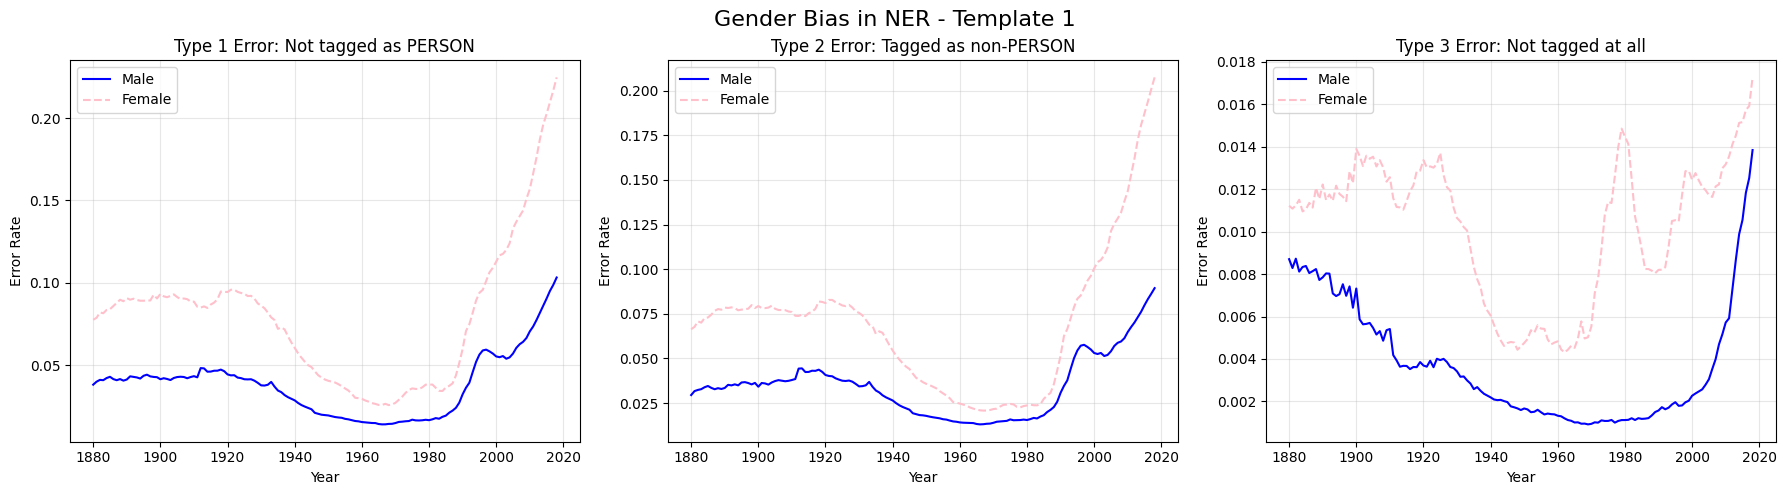

In [19]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 1)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 1)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 1', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## Template 2 Analysis

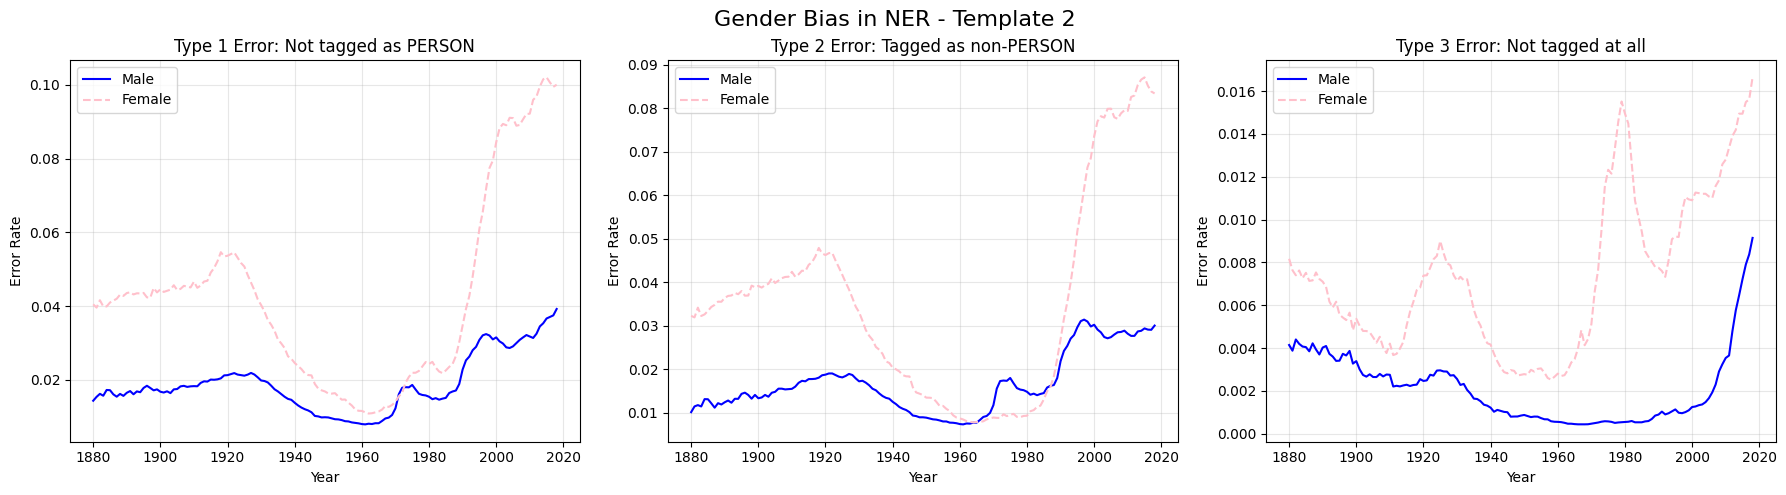

In [20]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 2)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 2)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 2', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## Template 3 Analysis

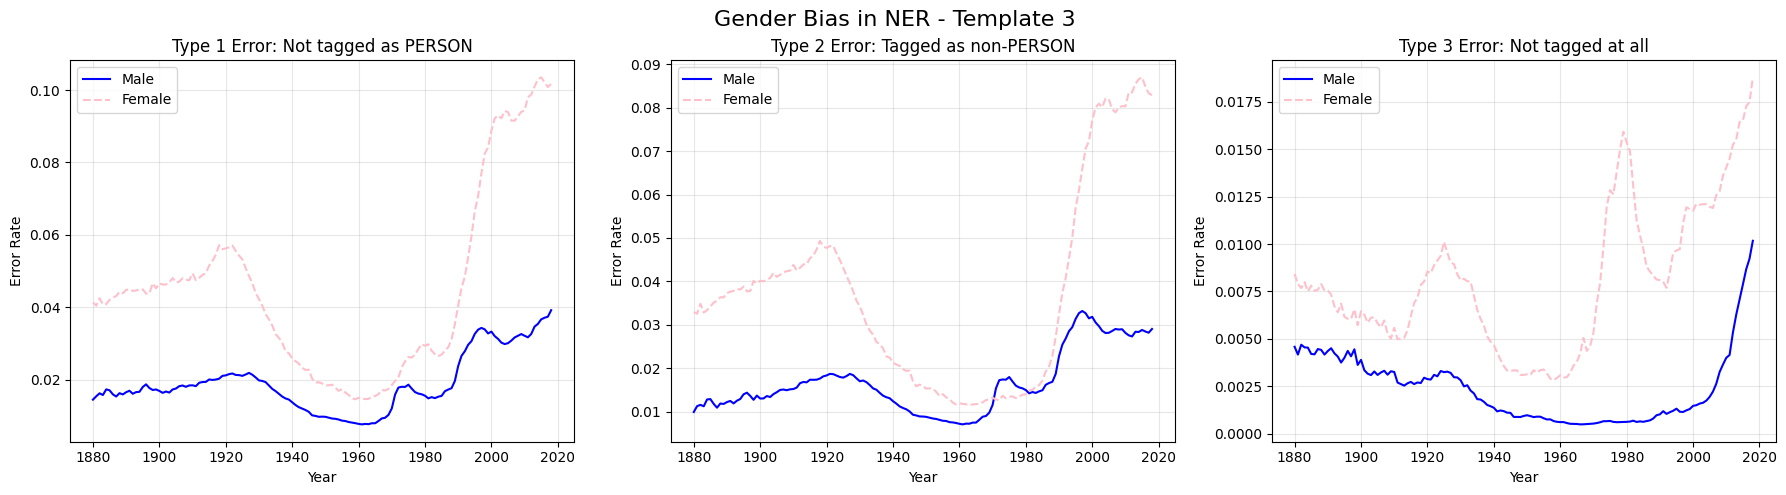

In [21]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 3)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 3)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 3', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## Template 4 Analysis

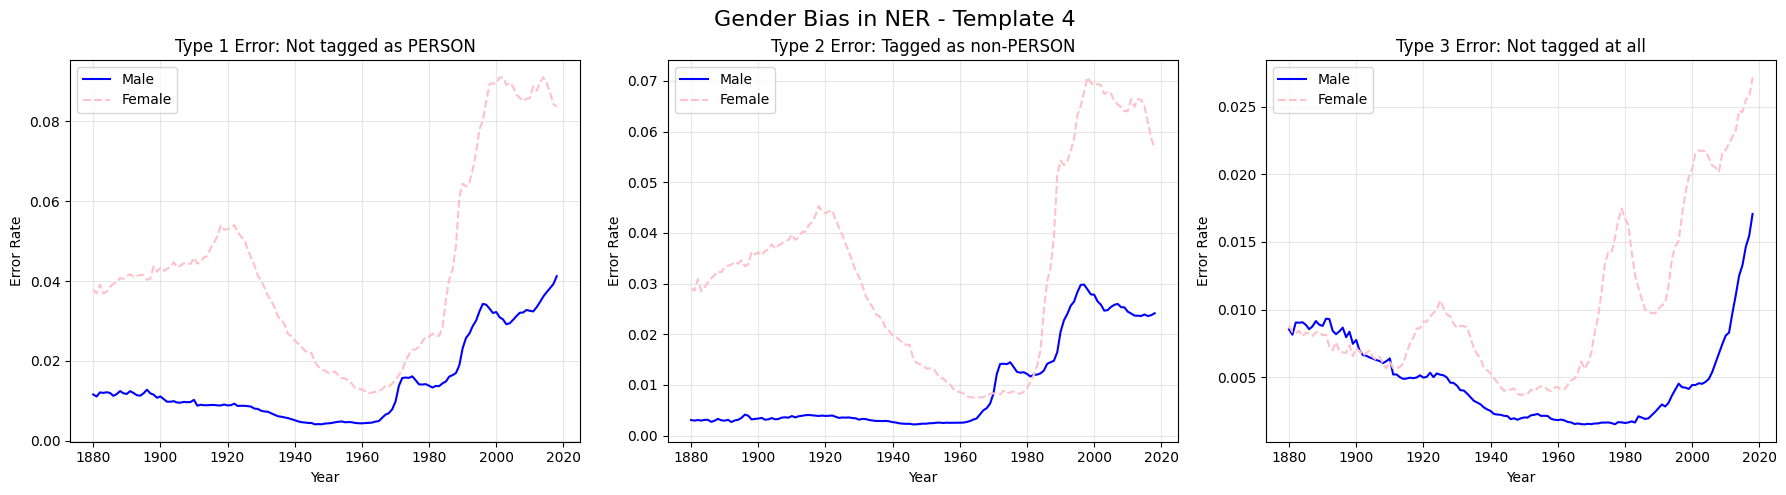

In [22]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 4)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 4)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 4', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## Template 5 Analysis

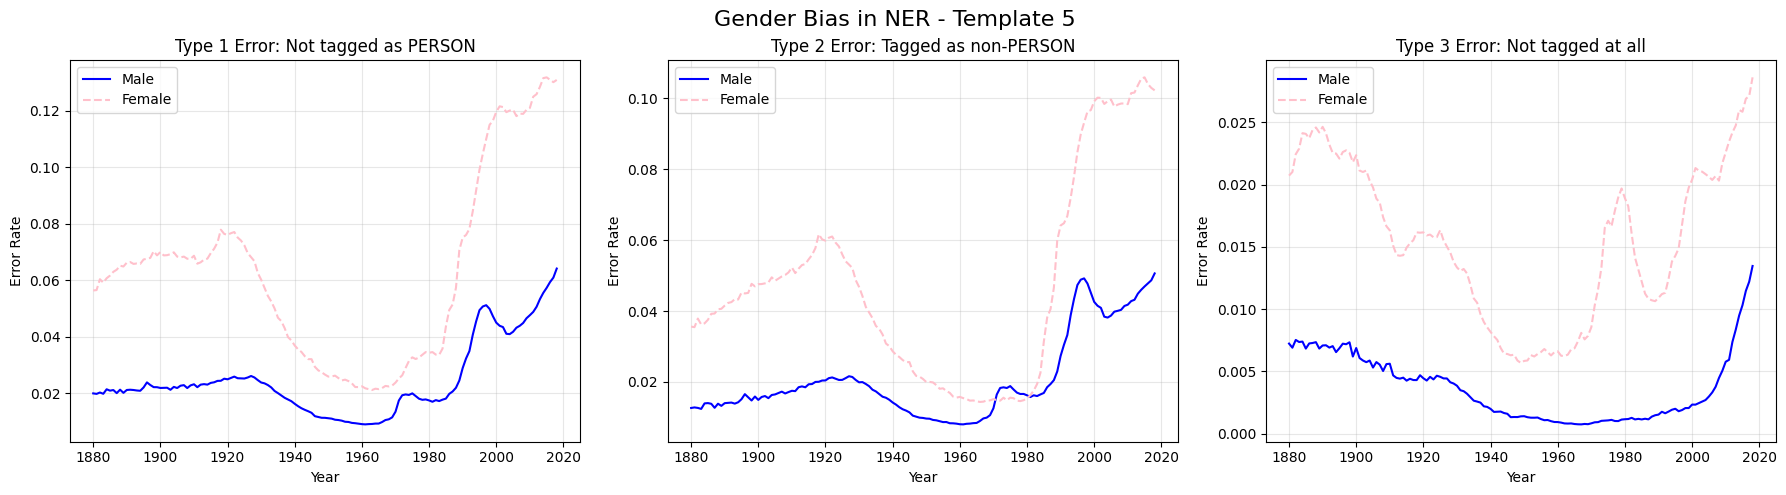

In [23]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 5)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 5)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 5', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Template 6 Analysis

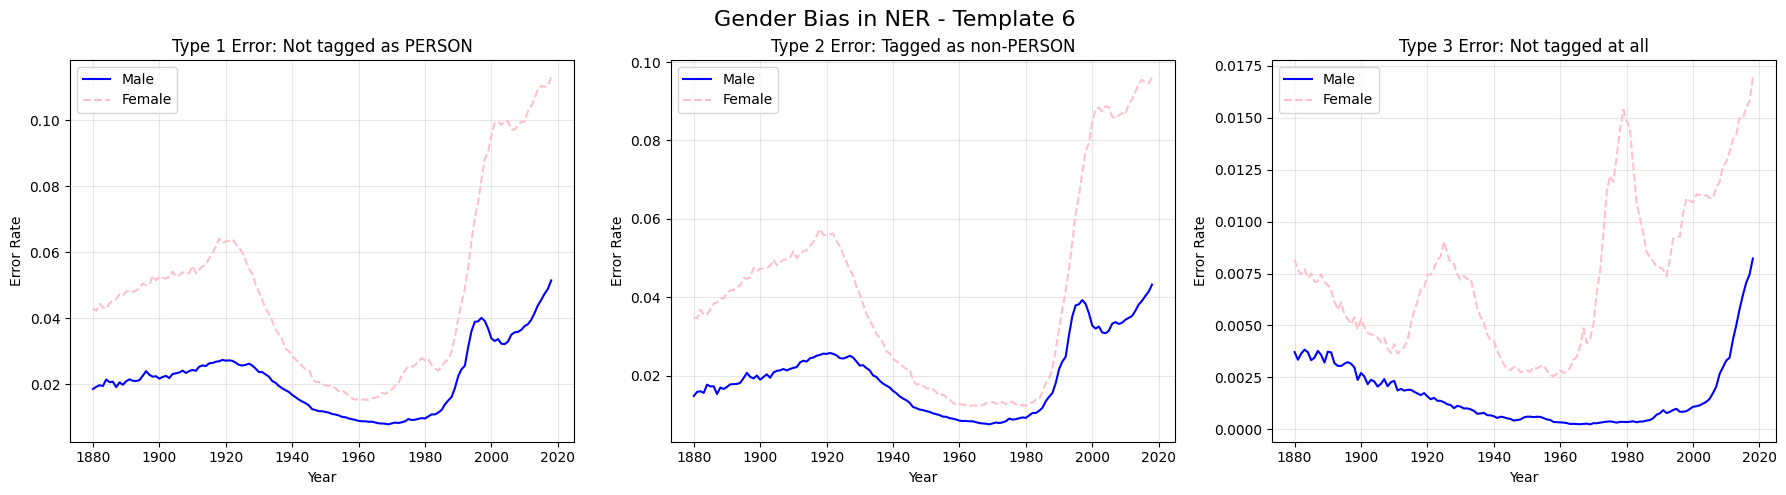

In [24]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 6)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 6)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 6', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Template 7 Analysis

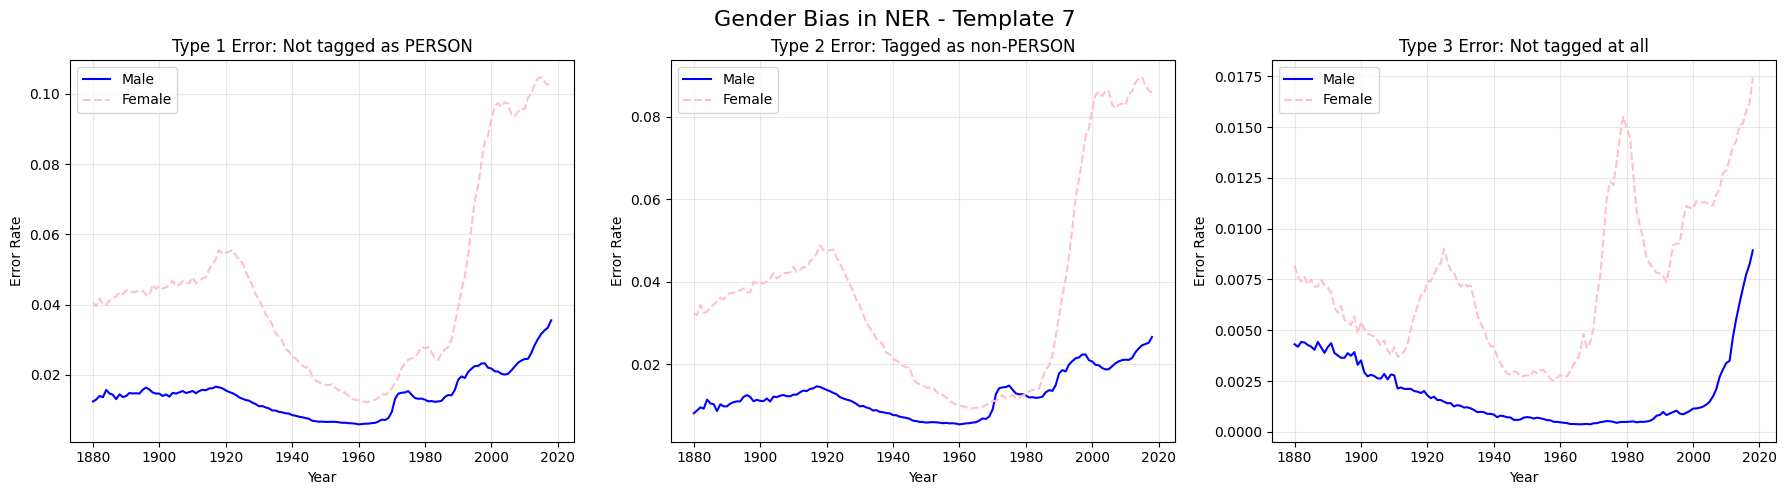

In [25]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 7)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 7)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 7', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Template 8 Analysis

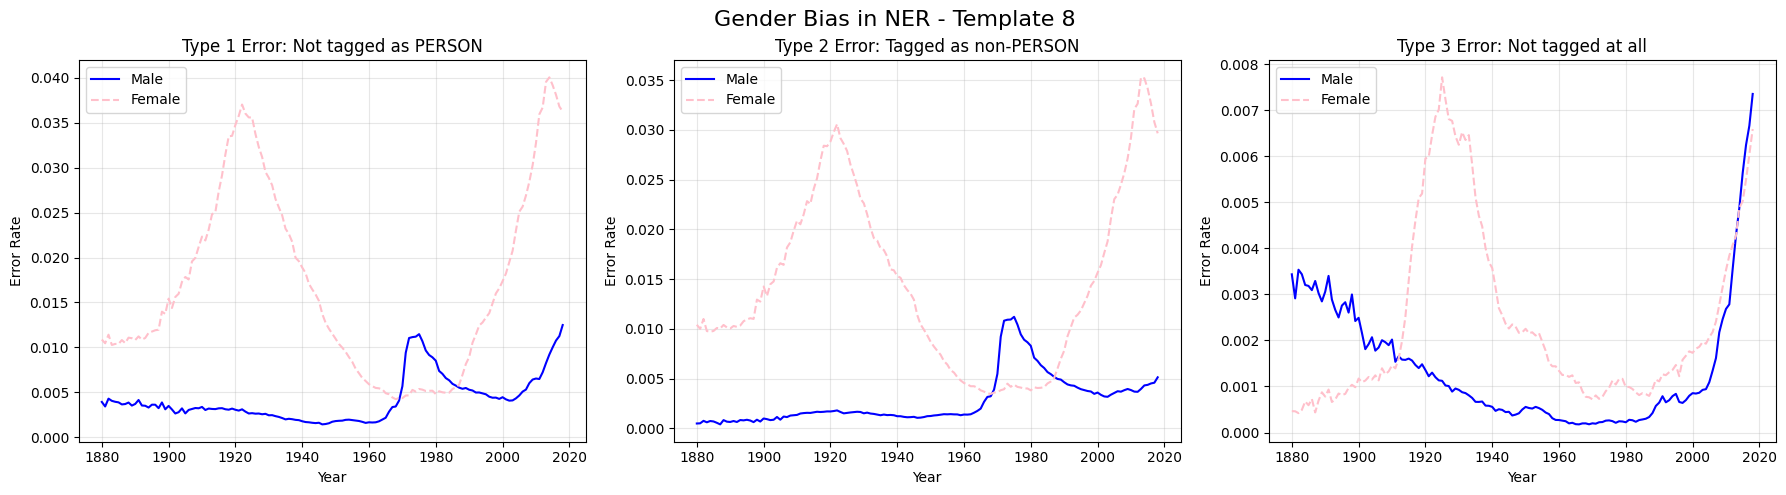

In [26]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 8)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 8)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 8', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Template 9 Analysis

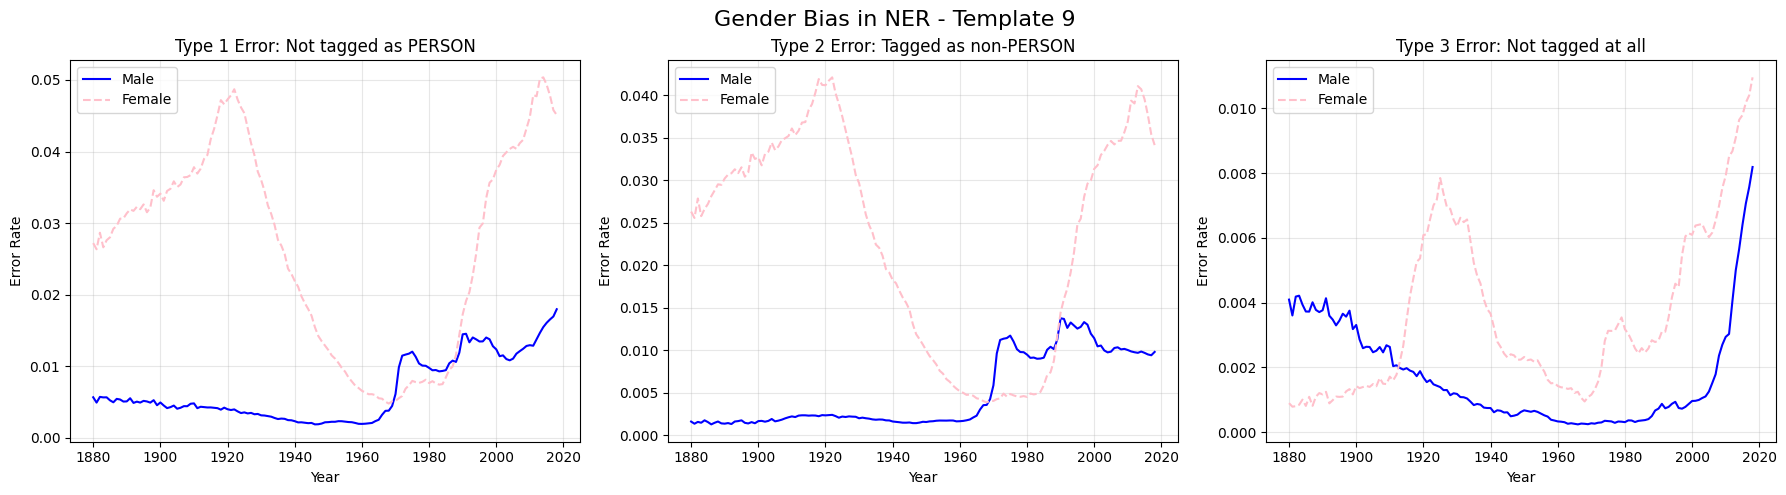

In [27]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    t1m, t2m, t3m = ner_inference_errors(year, "male", 9)
    t1f, t2f, t3f = ner_inference_errors(year, "female", 9)

    type1_errors_male.append(t1m)
    type2_errors_male.append(t2m)
    type3_errors_male.append(t3m)
    type1_errors_female.append(t1f)
    type2_errors_female.append(t2f)
    type3_errors_female.append(t3f)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Type 1 Error Plot
axes[0].plot(years, type1_errors_male, label='Male', color='blue')
axes[0].plot(years, type1_errors_female, label='Female', color='pink', linestyle='--')
axes[0].set_title('Type 1 Error: Not tagged as PERSON')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Error Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Type 2 Error Plot
axes[1].plot(years, type2_errors_male, label='Male', color='blue')
axes[1].plot(years, type2_errors_female, label='Female', color='pink', linestyle='--')
axes[1].set_title('Type 2 Error: Tagged as non-PERSON')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Type 3 Error Plot
axes[2].plot(years, type3_errors_male, label='Male', color='blue')
axes[2].plot(years, type3_errors_female, label='Female', color='pink', linestyle='--')
axes[2].set_title('Type 3 Error: Not tagged at all')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Error Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add an overall title
fig.suptitle('Gender Bias in NER - Template 9', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

### According to the plots you make, do you observe difference in the ability to recognize male and female names as PERSON entity types? How does the difference change over years? How does the difference change across different templates? Checking some error cases, where do you think the bias might come from? Can you think of any possible ways to mitigate the bias? 10pts.

#### <font color="red">Please type your response here.</font>
#### 1) Female names are easily to be identified as location names compared to male names. 2) 3) 4) The bias may come from the tradition to use male names to denote locations. To mitigate them, we can create different embeddings for the same name when they are person names and they are location names.